<a href="https://colab.research.google.com/github/Kabshah/AI-try/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"cupshah","key":"af5f6a202ed1974334507b48cad0bcaf"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!pip install kaggle

In [12]:
!kaggle datasets download -d phylake1337/fire-dataset

Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
fire-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
!unzip fire-dataset.zip -d /content/dataset

Archive:  fire-dataset.zip
  inflating: /content/dataset/fire_dataset/fire_images/fire.1.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.10.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.100.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.101.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.102.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.103.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.104.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.105.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.106.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.107.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.108.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.109.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.11.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.110.png

In [29]:
import os
print(os.listdir("/content/dataset"))

['fire_dataset']


In [28]:
data_dir = "/content/dataset/fire_dataset"

classes = os.listdir(data_dir)
print("Classes:", classes)

for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {count} images")


Classes: ['non_fire_images', 'fire_images']
non_fire_images: 244 images
fire_images: 755 images


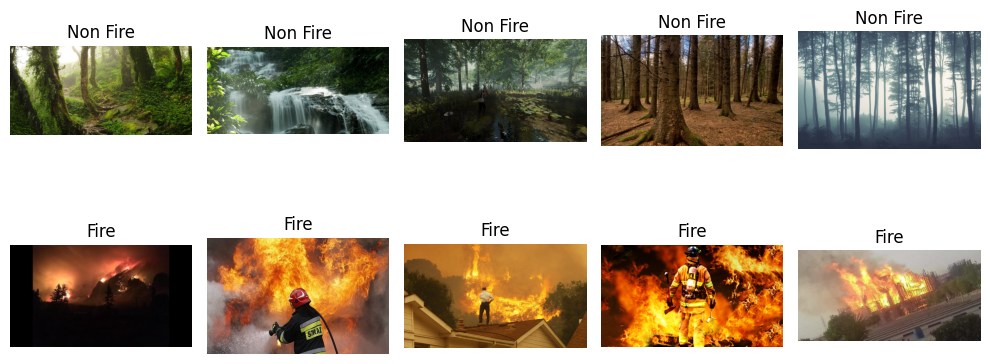

In [31]:
from PIL import Image
import numpy as np

plt.figure(figsize=(10,5))

for i, img_name in enumerate(non_fire_images):
    img_path = os.path.join(non_fire_dir, img_name)
    img = Image.open(img_path)
    img = np.array(img)
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title("Non Fire")
    plt.axis('off')

for i, img_name in enumerate(fire_images):
    img_path = os.path.join(fire_dir, img_name)
    img = Image.open(img_path)
    img = np.array(img)
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.title("Fire")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [32]:
!pip install split-folders
import splitfolders

input_folder = "/content/dataset/fire_dataset"
output_folder = "/content/dataset_split"

# Split into train (70%), validation (20%), test (10%)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.2, 0.1))


Copying files: 999 files [00:04, 209.02 files/s]


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalization (rescale pixel values)
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    output_folder + "/train",
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    output_folder + "/val",
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

test_gen = datagen.flow_from_directory(
    output_folder + "/test",
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False   # don’t shuffle, so we can compare predictions later
)


Found 698 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [34]:
print(train_gen.class_indices)

{'fire_images': 0, 'non_fire_images': 1}


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [39]:
# Building the CNN model
model = Sequential([

    # 1st Convolution + Pooling block
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3), padding="same"),
    MaxPooling2D((2,2)),

    # 2nd Convolution + Pooling block
    Conv2D(64, (3,3), activation='relu', padding="same"),
    MaxPooling2D((2,2)),

    # 3rd Convolution + Pooling block
    Conv2D(128, (3,3), activation='relu', padding="same"),
    MaxPooling2D((2,2)),

    # Flatten + Fully Connected Layers
    Flatten(),                         # convert 3D feature maps → 1D vector
    Dense(128, activation='relu'),     # hidden layer with 128 neurons
    Dropout(0.5),                      # prevent overfitting
    Dense(1, activation='sigmoid')     # output layer (binary: cat vs dog)
])

In [40]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_gen,                 # training data
    epochs=10,                 # number of passes through the dataset
    validation_data=val_gen    # validation data (to monitor performance)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7179 - loss: 0.7762 - val_accuracy: 0.9196 - val_loss: 0.1749
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9149 - loss: 0.2594 - val_accuracy: 0.9296 - val_loss: 0.2065
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9331 - loss: 0.1754 - val_accuracy: 0.9397 - val_loss: 0.1654
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9428 - loss: 0.1885 - val_accuracy: 0.9246 - val_loss: 0.1655
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9487 - loss: 0.1293 - val_accuracy: 0.9397 - val_loss: 0.1790
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9510 - loss: 0.1391 - val_accuracy: 0.9497 - val_loss: 0.1310
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9706 - loss: 0.0910 - val_accuracy: 0.9497 - val_loss: 0.1242
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9661 - loss: 0.0836 - val_accuracy: 0.9598 - val_loss:

In [43]:
model.save("cat_dog_cnn.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!
